# Bayesian Optimisation NN

### The purpose of the kernel is to demonstrate how to find an optimal set of hyper-parameters for various NN models


### UPDATES:

### v.11: Model architecture with 2-layers & Transfer learning + FE - Optimize for MS-KFold logloss 

    --> `hp`: `dense_units`, `activations`, `dropouts`

----------------

- v.10: Model architecture: 2048-1024-786  -  Optimize for MS-KFold logloss 

- v9: train with all features; best params

- v7: best params (tbc)

- v.1,2: Model architecture: 2048-X-X-X     
-   v.3: Model architecture: 2048-1024-X-X   --> hp: dense_units, dropouts, activations
- v.4-5: Model architecture: 2048-1024-512-X --> hp: dense_units, dropouts, activations, look_ahead + (fix compatibility issues)



# Imports

### NOTE: make sure you downgrade sklearn --> install it from the .whl (due to compatibility issues)

In [ ]:
!pip install ../input/my-wheels/scikit_learn-0.21.0-cp37-cp37m-manylinux1_x86_64.whl

# !pip install -U scikit-learn==0.21.0
# !pip install scikit-optimize==0.8.dev0

In [ ]:
import os
import gc
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import random
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import *
from skopt.utils import use_named_args

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

import sklearn
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import category_encoders as ce
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder


# print(os.listdir('../input/lish-moa'))

In [ ]:
skopt.__version__, sklearn.__version__

# Config

In [ ]:
DEBUG = False # True 
KAGGLE = True

N_FOLDS = 5    # 10
VERBOSE = 0 if not DEBUG else 1

N_TRIALS = 15   # 20

N_COMP_G = 600     # 100
N_COMP_C = 50      # 80, 10
N_CLUSTERS_G = 35
N_CLUSTERS_C = 10  # 5
VAR_THRES = 0.8   # 0.7
ENCODING = 'dummy'

# Clipping Thresholds
CLIP = True
p_min = 0.0001
p_max = 1-p_min

# Model hp
LR = 1e-3   # 5e-4
WD = 1e-5
EPOCHS = 60 if not DEBUG else 5
BATCH_SIZE = 128
SEED = 26

# Helpers

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed=42)

In [ ]:
# some helpers

# Function to calculate the mean log loss of the targets including clipping
def mean_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    metrics = []
    for target in range(206):
        metrics.append(log_loss(y_true[:, target], y_pred[:, target], labels=[0,1]))
    return np.mean(metrics)

def multi_log_loss(y_true, y_pred):
    metrics = []
    for _target in y_true.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels=[0,1]))
    return np.mean(metrics)


def getFold(df, fold):
    X_train = df[df.kfold != fold].loc[:, feature_cols]
    X_val = df[df.kfold == fold].loc[:, feature_cols]

    Y_train = df[df.kfold != fold].loc[:, target_cols]
    Y_val = df[df.kfold == fold].loc[:, target_cols]

    return X_train, X_val, Y_train, Y_val


# ***** Clustering **** #
def fe_cluster(train, test, n_clusters_g=35, n_clusters_c=10, SEED = 123):

    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])

    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test

    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test


# ***** FE stats **** #
def fe_stats(train, test):

    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])

    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)

    return train, test


def cells_sq(train, test):
    features_c = list(train_features.columns[776:876])
    for df in train, test:
        for col in features_c:
            df[f'{col}_sq'] = df[col].values ** 2
    return train, test


def process_data(data):
    data = pd.get_dummies(data, columns=['cp_time', 'cp_dose'], drop_first=True)
    return data

# def preprocess(df):
#     df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
#     df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     del df['sig_id']
#     return df


# Load & Preprocess data (add FE)

In [ ]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')

train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

ss = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [ ]:
G_COLS = [col for col in train_features.columns if col.startswith('g-')]
C_COLS = [col for col in train_features.columns if col.startswith('c-')]

print(len(G_COLS), len(C_COLS))

# make a copy for preprocessing
train = train_features.copy()
test = test_features.copy()

# -------
# scaling
# -------
scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution="normal")
# scaler = GaussRankScaler(epsilon=1e-3, interp_kind='linear')    #interp_kind: 'nearest', 'zero', 'slinear', 'quadratic', 'cubic',

n_train = len(train_features.values)
n_test = len(test_features.values)

# fit in train - transform test
scaler.fit(train_features[G_COLS + C_COLS].values)
train[G_COLS + C_COLS] = scaler.transform(train_features[G_COLS + C_COLS].values)
test[G_COLS + C_COLS] = scaler.transform(test_features[G_COLS + C_COLS].values)

print('> [RankGauss] tensors shape:', train.shape, test.shape)

# -------
# PCA 
# -------

# ----- GENES -----
data = pd.concat([train[G_COLS], test[G_COLS]])                      # on scaled features
# data = pd.concat([train_features[G_COLS], test_features[G_COLS]])      # on original-unscaled features

data2 = (PCA(n_components=N_COMP_G, random_state=42).fit_transform(data[G_COLS].values))
train_pca_genes = pd.DataFrame(data2[:train.shape[0]], columns=[f'pca_G-{i}' for i in range(N_COMP_G)])
test_pca_genes = pd.DataFrame(data2[-test.shape[0]:], columns=[f'pca_G-{i}' for i in range(N_COMP_G)])

# ----- CELLS -----
data = pd.concat([train[C_COLS], test[C_COLS]])                      # on scaled features
# data = pd.concat([train_features[C_COLS], test_features[C_COLS]])      # on original-unscaled  features

data2 = (PCA(n_components=N_COMP_C, random_state=42).fit_transform(data[C_COLS].values))
train_pca_cells = pd.DataFrame(data2[:train.shape[0]], columns=[f'pca_C-{i}' for i in range(N_COMP_C)])
test_pca_cells = pd.DataFrame(data2[-test.shape[0]:], columns=[f'pca_C-{i}' for i in range(N_COMP_C)])

# Merge all PCA features
train = pd.concat([train, train_pca_genes, train_pca_cells], axis=1)
test = pd.concat([test, test_pca_genes, test_pca_cells], axis=1)

del data2, train_pca_genes, test_pca_genes, train_pca_cells, test_pca_cells
gc.collect()

print('> [PCA] tensors shape:', train.shape, test.shape)


# -------
# Variance Threshold 
# -------

num_cols = [col for col in train.columns if train[col].dtype == np.float]
other_cols = [col for col in train.columns if train[col].dtype != np.float]

var_thresh = VarianceThreshold(0.8)  # VAR_THRES 0.7 - 0.8

# fit train/test separate
train_features_transformed = var_thresh.fit_transform(train.iloc[:, 4:])   # num_cols
test_features_transformed = var_thresh.transform(test.iloc[:, 4:])

tmp_tr = pd.DataFrame(train_features[other_cols].values.reshape(-1, 4), columns=other_cols)
train = pd.concat([tmp_tr, pd.DataFrame(train_features_transformed)], axis=1)

tmp_te = pd.DataFrame(test_features[other_cols].values.reshape(-1, 4), columns=other_cols)
test = pd.concat([tmp_te, pd.DataFrame(test_features_transformed)], axis=1)

del tmp_tr, tmp_te
gc.collect()

print('> [Var. Threshold] tensors shape:', train.shape, test.shape)


# train, test = fe_cluster(train,test)
# print('> [FE Clustering] tensors shape:', train.shape, test.shape)

# train, test = fe_stats(train, test)
# print('> [FE stats] tensors shape:', train.shape, test.shape)

# -------
# Filter ctl samples
# -------
train = train.merge(train_targets_scored, on='sig_id')

train = train[train['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)
# test = test[test['cp_type'] != 'ctl_vehicle'].reset_index(drop=True)       # TODO: don't remove from test

train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

target = train[train_targets_scored.columns]
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

train_targets = target[target_cols]

print('> Filter CTL samples:', train.shape, test.shape, train_targets.shape)



# -------
# encode categ cols
# -------

train = process_data(train)
test = process_data(test)

feature_cols = [c for c in train.columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold', 'sig_id']]

num_features = len(feature_cols)
num_targets = len(target_cols)

print('No. of features:', num_features)     # 1091
print('No. of target cols:', num_targets) 

In [ ]:
# Prepare non-scored data

transfer_data = train.copy()
transfer_data = transfer_data.merge(train_targets_nonscored, how='inner', on='sig_id')
transfer_data = transfer_data.drop(['sig_id'], axis=1)

Y_transfer = transfer_data.loc[:, train_targets_nonscored.columns[1:]]
transfer_data = transfer_data.loc[:, feature_cols]

print('Transfer learning from non-scored targets dataset shape:', transfer_data.shape, Y_transfer.shape)
# print(transfer_data.head())

In [ ]:
# make folds 

folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=N_FOLDS)

for f, (t_idx, v_idx) in enumerate(mskf.split(train, target[target_cols])):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds.sample(10)

# Use Bayesian Optimization for Hyper-parameter search
The idea with Bayesian optimization is to construct another model of the search-space for hyper-parameters. One kind of model is known as a Gaussian Process. This gives us an estimate of how the performance varies with changes to the hyper-parameters. Whenever we evaluate the actual performance for a set of hyper-parameters, we know for a fact what the performance is - except perhaps for some noise. We can then ask the Bayesian optimizer to give us a new suggestion for hyper-parameters in a region of the search-space that we haven't explored yet, or hyper-parameters that the Bayesian optimizer thinks will bring us most improvement. We then repeat this process a number of times until the Bayesian optimizer has built a good model of how the performance varies with different hyper-parameters, so we can choose the best parameters.

The flowchart of the algorithm is roughly:

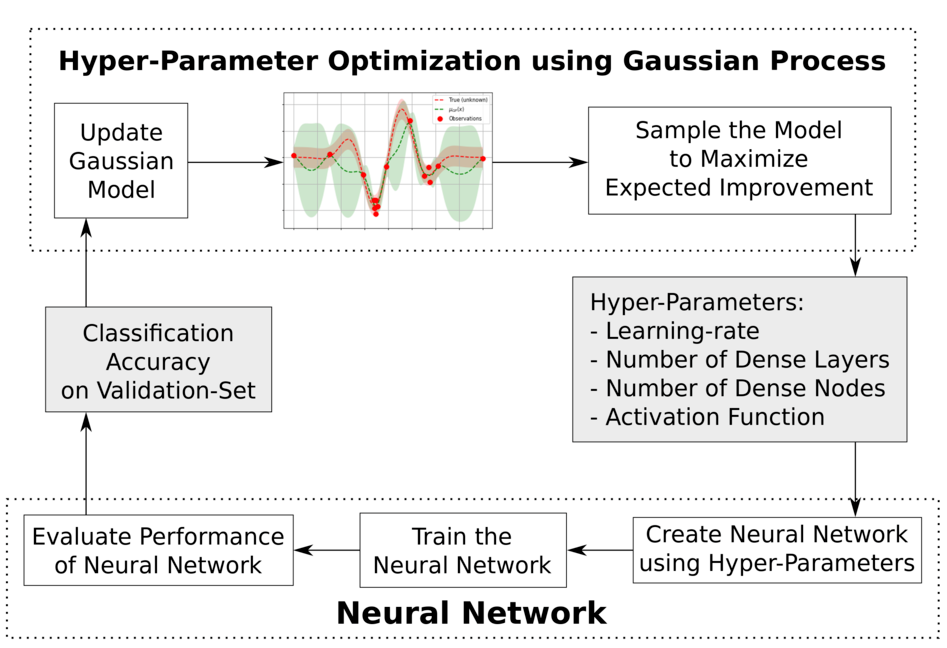

## NN architrecture & hyper-parameters

In [ ]:
# define the hp search space

dim_num_dense_nodes_1 = Integer(low=512, high=2048, name='num_dense_nodes_1')
dim_activation = Categorical(categories=[tf.nn.relu, tf.nn.elu, tf.nn.leaky_relu], name='activation')
dim_dropout1 = Integer(low=1, high=5, name='dp1')
dim_dropout2 = Integer(low=1, high=5, name='dp2')

# dim_num_dense_nodes_2 = Integer(low=512, high=1024, name='num_dense_nodes_2')
# dim_num_dense_nodes_3 = Integer(low=256, high=512, name='num_dense_nodes_3')
# dim_dropout3 = Integer(low=1, high=5, name='dp3')
# dim_dropout4 = Integer(low=1, high=5, name='dp4')
# dim_smooth = Real(low=0.0001, high=0.005, name='smooth')
# dim_learning_rate = Real(low=1e-4, high=1e-1, prior='uniform', name='learning_rate')
# dim_look_ahead = Integer(low=5, high=15, name='look_ahead')
# dim_num_dense_layers = Integer(low=2, high=10, name='num_dense_layers')

dimensions = [
    dim_num_dense_nodes_1,
    dim_activation,
    dim_dropout1,
    dim_dropout2,
]


# set default params - make sure are within the search space
default_params = [512, tf.nn.relu, 5, 5]  

assert len(default_params)==len(dimensions), 'Error: check shapes!'

## Create Model

In [ ]:
n_inputs = len(feature_cols) # len(top_feats)
n_outs = len(target_cols)

def create_model(num_dense_nodes_1, activation, dp1, dp2, out_size=206):
    
    inp = Input(shape=n_inputs)
    x = BatchNormalization()(inp)
    x = Dropout(0.2)(x)
    x = tfa.layers.WeightNormalization(Dense(num_dense_nodes_1))(x)
    #   x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dp1*0.1)(x)

    x = BatchNormalization()(x)
    x = tfa.layers.WeightNormalization(Dense(num_dense_nodes_1))(x)
    #   x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Dropout(dp2*0.1)(x)
    
    out = tfa.layers.WeightNormalization(Dense(out_size, activation="sigmoid"))(x)                            
    model = tf.keras.models.Model(inp, out)
    
    # optimizers
    #     opt = tf.keras.optimizers.Adam(lr=1e-3)   # learning_rate
    #     opt = tfa.optimizers.SWA(opt, 100)
    opt = tfa.optimizers.AdamW(learning_rate=LR, weight_decay=WD)
    #     opt = tfa.optimizers.Lookahead(opt, sync_period=int(look_ahead))
    
    # compile model
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=p_min), 
                  metrics=[tf.keras.losses.BinaryCrossentropy(), 'AUC'])

    return model


def transfer_weight(model_source, model_dest):
    for i in range(len(model_source.layers[:-1])):
        model_dest.layers[i].set_weights(model_source.layers[i].get_weights())
    return model_dest

# Fittness Function to Optimize


This is the function that creates and trains a neural network with the given hyper-parameters, and then evaluates its performance on the validation-set. The function then returns the so-called fitness value (aka. objective value), which is the negative classification accuracy on the validation-set. It is negative because skopt performs minimization instead of maximization.

The main steps that we perform are:

- build and train a network with given hyper-parameters
- evaluate the model performance with the validation dataset
- It returns the fitness value, in our case the logloss error.




Note the function decorator `@use_named_args` which wraps the fitness function so that it can be called with all the parameters as a single list, for example: `fitness(x=[1e-4, 3, 256, 'relu'])`. This is the calling-style skopt uses internally.

In [ ]:
path_best_model = './model.h5'
best_loss = np.inf

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes_1, activation, dp1, dp2):   
    
    """
    Hyper-parameters:
    num_dense_nodes:   Number of nodes in layer 4.
    activation:        Activation function for all layers.
    dp:                Dropout rates (x4)
    """

    # Print the hyper-parameters.
    print()
    print('-'*20)
    print('num_hidden_size:', num_dense_nodes_1)
    print('activation:',activation)
    print('dropout 1:', dp1*0.1)
    print('dropout 2:', dp2*0.1)
    print('-'*20)

    
    fold_log_loss = 0
    
    for fold_id in range(N_FOLDS):
        
        print(f'Fold: {fold_id}/{N_FOLDS}')
        K.clear_session()
        
        x_train, x_val, y_train, y_val = getFold(folds, fold_id)
        x_test = test[feature_cols]

        # Pretrain model with non-scored targets
        print('> Pretrain model with non-scored targets')
        model_nonscored = create_model(num_dense_nodes_1, activation, dp1, dp2, out_size=Y_transfer.shape[1])
        
        cp = ModelCheckpoint(f'model_learned_fold{fold_id}.h5', monitor='val_binary_crossentropy', save_best_only=True, save_weights_only=True, verbose=0)
        rlr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.3, patience=5, verbose=0)   # epsilon=1e-4, mode='min'
        es = EarlyStopping(monitor='val_binary_crossentropy', patience=15, mode='min', verbose=0)
        
        model_nonscored.fit(x_train.values, Y_transfer.iloc[x_train.index].values,
                            epochs=60,
                            batch_size=128,
                            validation_data=(x_val.values, Y_transfer.iloc[x_val.index].values),
                            callbacks=[es, cp, rlr],
                            verbose=VERBOSE)
        
        model_nonscored.load_weights(f'model_learned_fold{fold_id}.h5')
        
        #  Training model with transfer learning
        print('> Training with transfered weights')
        model = create_model(num_dense_nodes_1, activation, dp1, dp2, out_size=206)

        model = transfer_weight(model_source=model_nonscored, model_dest=model)
        for layer in model.layers:
            layer.trainable = True

        checkpoint_path = f'model_fold{fold_id}.h5'
        cp = ModelCheckpoint(checkpoint_path, monitor='val_binary_crossentropy', verbose=0, save_best_only=True, mode='min')
        rlr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, verbose=0) # epsilon=1e-4, mode='min'
        es = EarlyStopping(monitor='val_binary_crossentropy', patience=15, mode='min')

        # train the model
        hist = model.fit(x_train.values, y_train.values,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_val.values, y_val.values),
                         callbacks=[es, cp, rlr],
                         verbose=VERBOSE)
    
    
        # Get the error on the validation-set
        log_loss = min(hist.history['val_binary_crossentropy'])   
        
        fold_log_loss += log_loss/N_FOLDS

        # Print the classification accuracy.
        
        print(f"> Fold {fold_id} Logloss: {log_loss}")
        print('-'*20)

#     # Save the model if it improves on the best-found performance.
#     global best_loss

#     # If the classification accuracy of the saved model is improved ...
#     if fold_log_loss < best_loss:
        
#         # Save the new model & Update the error
#         model.save(path_best_model)
#         best_loss = fold_log_loss

#     # Delete the Keras model with these hyper-parameters from memory.
#     del model
#     gc.collect()
    
#     # Clear the Keras session, to empty the TensorFlow graph 
#     K.clear_session()
    
    return fold_log_loss

In [ ]:
# # check objective function (uncomment bellow if you like to test)

# fitness(default_params)

# Run Bayesian Optimization

We may control the runtime of the optimization process by `N_TRIALS`: selecting the no. of evaluation runs

In [ ]:
search_result = skopt.gp_minimize(func=fitness,   
                            dimensions=dimensions,
                            acq_func='EI',    #  'gp_hedge'       
                            n_calls=N_TRIALS,
                            random_state=SEED,
                            x0=default_params)

# Results

In [ ]:
print('optimal hyper-parameters') 
print()
print(f'dense_units 1: {search_result.x[0]}')
print(f'activation: {search_result.x[1]}')
print(f'dropout 1: {search_result.x[2]}')
print(f'dropout 2: {search_result.x[3]}')

# ----------------------------
# optimal hyper-parameters v.3
# ----------------------------
# dense_units 3: 511
# activation: elu
# dropout 1: 3
# dropout 2: 4
# dropout 3: 5
# dropout 4: 2

In [ ]:
pd.DataFrame(sorted(zip(search_result.func_vals, search_result.x_iters)), index=np.arange(N_TRIALS), columns=['score', 'params'])

### Let's visualize the progress of the whole optimization session, where the fitness values are shown on y-axis.

In [ ]:
%matplotlib inline
plot_convergence(search_result)

In [ ]:
# create a list for plotting
dim_names = ['num_dense_nodes_1', 'activation', 'dropout_1', 'dropout_2']

# %matplotlib inline
plot_objective(result=search_result, dimensions=dim_names);

# Reproduce Model with best hyperparams

In [ ]:
# create model with best hyperparams

model = create_model(*search_result.x)
model.summary()

In [ ]:

# oof = targets.copy()
# subm.loc[:, target_cols] = 0
# oof.loc[:, target_cols] = 0


# for fold_id in range(N_FOLDS):
    
#     print(f'Fold: {fold_id}/{N_FOLDS}')
#     K.clear_session()
        
#     x_train, x_val, y_train, y_val = getFold(folds, fold_id)
#     x_test = test[feature_cols]

#     checkpoint_path = f'best_model_fold_{fold_id}.h5'
#     cp = ModelCheckpoint(checkpoint_path, monitor='val_binary_crossentropy', verbose=1, save_best_only=True, mode='min')
#     rlr = ReduceLROnPlateau(monitor='val_binary_crossentropy', factor=0.1, patience=5, verbose=0) # epsilon=1e-4, mode='min'
#     es = EarlyStopping(monitor='val_binary_crossentropy', patience=15, mode='min')

#     model = create_model(*search_result.x)

#     model.fit(x_train.values, y_train.values,
#               validation_data=(x_val.values, y_val.values),
#               epochs=EPOCHS, 
#               batch_size=BATCH_SIZE, 
#               callbacks=[es, rlr, cp], 
#               verbose=VERBOSE)

#     model.load_weights(checkpoint_path)

#     subm.loc[ss.sig_id.isin(test.sig_id), target_cols] += model.predict(x_test.values)
#     oof.loc[x_val.index, target_cols] += model.predict(x_val.values)
#     print('-'*20)

# subm.loc[:, target_cols] /= FOLDS

In [ ]:
# metrics = []
# for _target in target_cols:
#     metrics.append(log_loss(targets.loc[:, _target], oof.loc[:, _target]))
    
# print(f'OOF Metric: {np.mean(metrics).round(8)}')

# Submission!

In [ ]:
# if CLIP:
#     subm.loc[:, target_cols] = np.clip(subm.loc[:, target_cols], p_min, p_max)
    
# subm.loc[test_features['cp_type']=='ctl_vehicle', target_cols] = 0
# subm.to_csv('submission.csv', index=False)
# print('> Submission saved!')

In [ ]:
# subm.head()

## Credits

- [towards-data-science article](https://towardsdatascience.com/bayesian-hyper-parameter-optimization-neural-networks-tensorflow-facies-prediction-example-f9c48d21f795)

- [skopt documentation and examples](https://scikit-optimize.github.io/stable/user_guide.html)



## Reference notebooks

- https://www.kaggle.com/stanleyjzheng/baseline-nn-with-k-folds 
- https://www.kaggle.com/simakov/multilabel-neural-network
- https://www.kaggle.com/ravy101/drug-moa-tf-keras-starter